<h1 align=center><font size = 5>Budapest rental fee regression analysis</font></h1>

__Hello and Welcome!__

The purpose of this script is the following:  
* Load data from DB2 on Cloud
* Feature engineer the data
* Convert price into euro from HUF
* Identify outliers
* Identify pairwise relationships
* Identify correlations
* Null handling
* Create models: linear, ridge, lasso & elasticNet



In [1]:
# Import used packages
import pandas as pd
import numpy as np
import ibm_db
import ibm_db_dbi
import matplotlib.pyplot as plt
import seaborn as sns
from currency_converter import CurrencyConverter
from scipy import stats
from scipy.stats import norm, skew
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
from dotenv import load_dotenv
from pathlib import Path
import os

In [2]:
# Load & Store user-specific variables
load_dotenv(Path('.') / 'real_estate_project.env')
DSN_HOST = os.getenv("DSN_HOST")
DSN_UID = os.getenv("DSN_UID")
DSN_PWD = os.getenv("DSN_PWD")
DIR = os.getenv("SCRIPT_LOC")

In [3]:
# Create dsn connection
dsn_driver = "{IBM DB2 ODBC DRIVER}"
dsn_database = "BLUDB"            # e.g. "BLUDB"
dsn_port = "50000"                # e.g. "50000" 
dsn_protocol = "TCPIP"            # i.e. "TCPIP"

dsn = (
    "DRIVER={0};"
    "DATABASE={1};"
    "HOSTNAME={2};"
    "PORT={3};"
    "PROTOCOL={4};"
    "UID={5};"
    "PWD={6};").format(dsn_driver, dsn_database, DSN_HOST, dsn_port, dsn_protocol, DSN_UID, DSN_PWD)

#Create database connection

try:
    conn = ibm_db.connect(dsn, "", "")
    print ("Connected to database!")

except:
    print ("Unable to connect: ", ibm_db.conn_errormsg() )

Connected to database!


In [4]:
#connection for pandas
pconn = ibm_db_dbi.Connection(conn)

#query statement to retrieve all rows in BP_REAL_ESTATE table
selectQuery = "SELECT STREET, DISTRICT, AREA_M2, ROOMS, \
        PRICE, PROPERTY_CONDITION, \
       COMFORT, ENERGY_USAGE, FLOOR, LIFT, BUILDING_HEIGHT, \
       INNER_HEIGHT, AIR_CONDITIONING, FURNISHED, \
       UTILITIES_EXPENSE, \
        WHEELCHAIR_ACCESSIBLE, \
       ORIENTATION, VIEW, BALCONY, HAS_GARDEN, HAS_ATTIC, \
       HAS_EQUIPMENT, PET, SMOKING, PARKING, PANEL_PROGRAM FROM RSM70564.BP_RENT_FULL"

#retrieve the query results into a pandas dataframe
df = pd.read_sql(selectQuery, pconn)


In [5]:
# People signal that the utilities are in the price by not filling in the column
# Same with Balcony size, therefore
# Replace null values with 0

numerical_cols = ['UTILITIES_EXPENSE', 'BALCONY']
df[numerical_cols] = df[numerical_cols].fillna(0)

In [6]:
# Feature engineering
# Replace nomial values with ordinal (if it's really ordinal)
# and convert really numeric values to numeric

df.PROPERTY_CONDITION.replace(['renovated', 'new', 'good condition', None, 'medium condition',
                                'needs renovation', 'unfinished'],
                              [5,6,4,None,3,2,1],inplace=True)
df.COMFORT.replace([None, 'whole', 'double', 'luxury', 'one', 'half'],
                              [None,3,4,5,2,1],inplace=True)
df.HAS_GARDEN.replace([None, 'no', 'yes'],
                        [None,0,1],inplace=True)
df.HAS_ATTIC.replace([None, 'no', 'yes'],
                        [None,0,1],inplace=True)
df.HAS_EQUIPMENT.replace([None, 'no', 'yes'],
                        [None,0,1],inplace=True)
df.LIFT.replace([None, 'no', 'yes'],
                        [None,0,1],inplace=True)
df.INNER_HEIGHT.replace(['3m >', '3m <'],
                        [1,2],inplace=True)
df.drop(df.loc[(df['FLOOR']== '0>') | (df['FLOOR']=='10<')].index, inplace=True)
df.drop(df.loc[df['BUILDING_HEIGHT']=='10<'].index, inplace=True)
df.BUILDING_HEIGHT.replace(['5', '4', '3', None, '7', '6', '10', '9', '2', '8',
                           'ground floor only'],
                        [5,4,3,None,7,6,10,9,2,8,1],inplace=True)
df.ENERGY_USAGE.replace(['AA', 'A+', 'EE', 'AA++', 'DD', 'AA+', 'A', 'CC', 'BB', 'B',
                       'G', 'C', 'HH', 'FF', 'F', 'GG', 'E', 'D', 'H'],
                    [17,16,8,19,10,18,15,12,14,13,
                     3,11,2,6,5,4,7,9,1],inplace=True)
df.AIR_CONDITIONING.replace([None, 'no', 'yes'],
                        [0,0,1],inplace=True)
df.FURNISHED.replace(['partially', 'yes', None, 'no', 'by arrangement'],[3,4,None,1,2],inplace=True)
df.WHEELCHAIR_ACCESSIBLE.replace([None, 'no', 'yes'],
                        [0,0,1],inplace=True)
df.PET.replace(['not allowed', 'allowed', None],
                        [0,1,None],inplace=True)
df.PARKING.replace(['paid', 'free', None],
                        [0,1,None],inplace=True)
df.PANEL_PROGRAM.replace([None, 'participated', 'did not participate'],
                        [None,1,0],inplace=True)
df['FLOOR'] = pd.to_numeric(df['FLOOR'])
df['BUILDING_HEIGHT'] = pd.to_numeric(df['BUILDING_HEIGHT'])

In [7]:
# Set up currency converter for converting the HUF PRICE to EUR PRICE
c = CurrencyConverter()
PRICE_EUR_tags = []
for i in df.PRICE:
    price = c.convert(i, 'HUF', 'EUR')
    PRICE_EUR_tags.append(price)

df['PRICE'] = PRICE_EUR_tags

# Round the EUR PRICE to the nearest whole number
df['PRICE'] = df['PRICE'].round()
print('HUF converted into EUR!')

UTILITIES_tags = []
for i in df.UTILITIES_EXPENSE:
    price = c.convert(i, 'HUF', 'EUR')
    UTILITIES_tags.append(price)

df['UTILITIES_EXPENSE'] = UTILITIES_tags

# Round the EUR PRICE to the nearest whole number
df['UTILITIES_EXPENSE'] = df['UTILITIES_EXPENSE'].round()

PRICE = df['PRICE']

HUF converted into EUR!


In [8]:
# Identify numeric cols and store them in a variable
# use the numeric cols to identify outliers

numerical_cols = df.select_dtypes(exclude = ['object'])
numerical_cols.dropna(axis='columns', inplace=True)
numerical_cols = numerical_cols.columns
z = np.abs(stats.zscore(df[numerical_cols]))
df_o = df
df_o = df_o[(z < 3).all(axis=1)]

# Remove outliers and check the before and after rowcount
print('Shape before outliers: ', df.shape)
print('Shape after outliers: ', df_o.shape)

Shape before outliers:  (12944, 26)
Shape after outliers:  (12447, 26)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [9]:
# descriptive statistics summary
# describe the percentiles of price on the whole dataset
pd.set_option('float_format', '{:f}'.format)
df['PRICE'].describe()

count    12944.000000
mean       873.561109
std       6232.540495
min          3.000000
25%        423.000000
50%        544.000000
75%        846.000000
max     422859.000000
Name: PRICE, dtype: float64

In [10]:
# # describe the percentiles of price on the dataset after outliers
df_o['PRICE'].describe()

count   12447.000000
mean      713.624729
std       491.702931
min         3.000000
25%       423.000000
50%       544.000000
75%       816.000000
max      7901.000000
Name: PRICE, dtype: float64

Skewness: 2.833663
Kurtosis: 13.044346


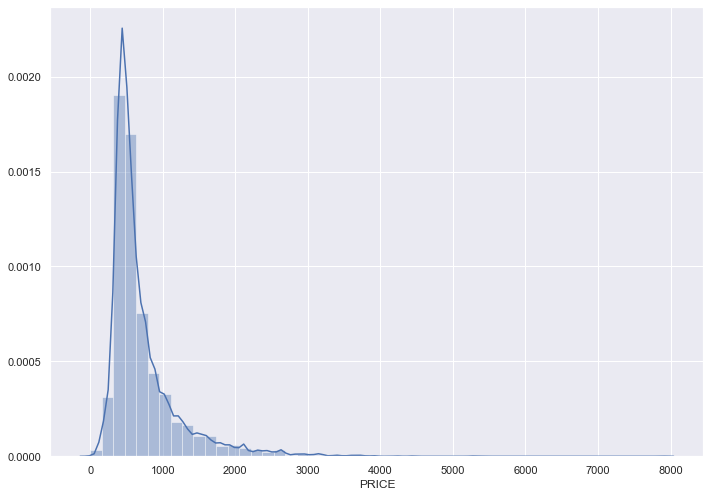

In [11]:
#histogram
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(df_o['PRICE'])
#skewness and kurtosis
print("Skewness: %f" % df_o['PRICE'].skew())
print("Kurtosis: %f" % df_o['PRICE'].kurt())

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


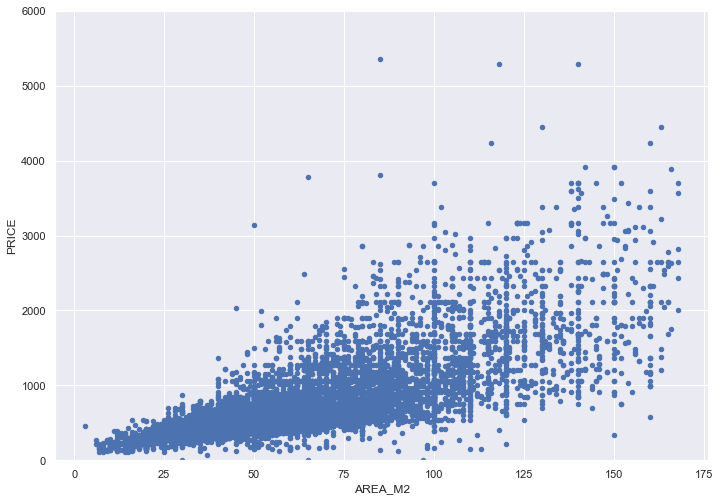

In [12]:
#scatter plot grlivarea/saleprice
var = 'AREA_M2'
data = pd.concat([df_o['PRICE'], df_o[var]], axis=1)
data.plot.scatter(x=var, y='PRICE', ylim=(0,6000));



'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


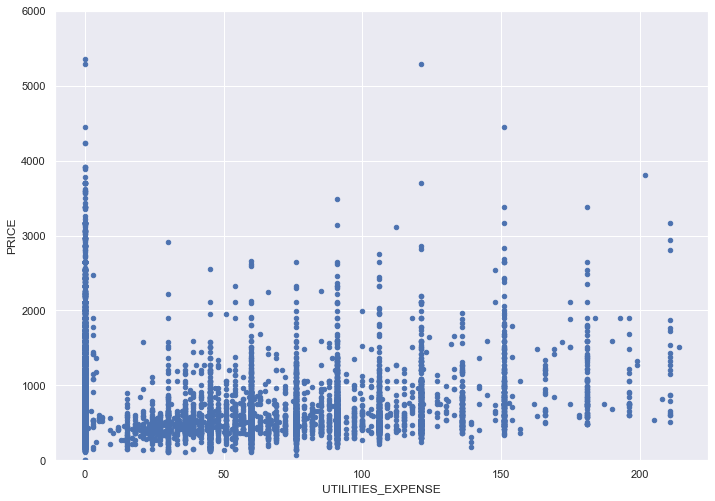

In [13]:
#scatter plot totalbsmtsf/saleprice
var = 'UTILITIES_EXPENSE'
data = pd.concat([df_o['PRICE'], df_o[var]], axis=1)
data.plot.scatter(x=var, y='PRICE', ylim=(0,6000));

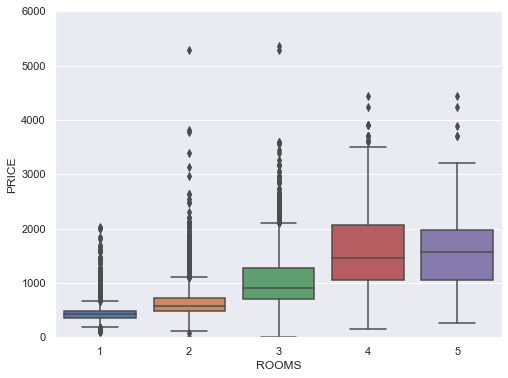

In [14]:
var = 'ROOMS'
data = pd.concat([df_o['PRICE'], df_o[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="PRICE", data=data)
fig.axis(ymin=0, ymax=6000);

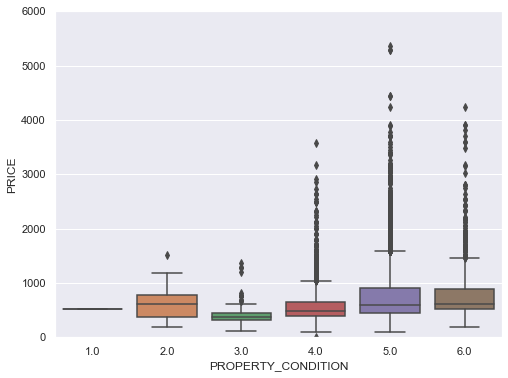

In [15]:
#box plot overallqual/saleprice
var = 'PROPERTY_CONDITION'
data = pd.concat([df_o['PRICE'], df_o[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="PRICE", data=data)
fig.axis(ymin=0, ymax=6000);

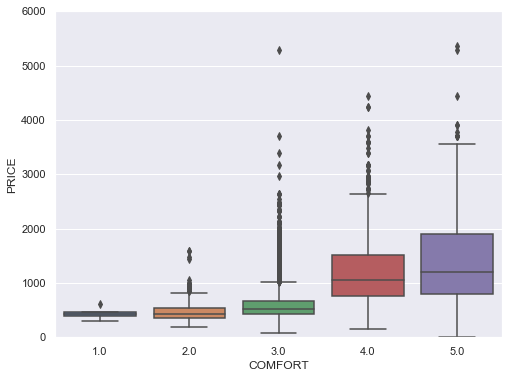

In [16]:
#box plot overallqual/saleprice
var = 'COMFORT'
data = pd.concat([df_o['PRICE'], df_o[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="PRICE", data=data)
fig.axis(ymin=0, ymax=6000);

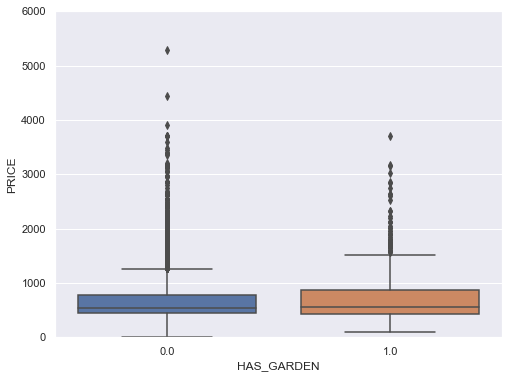

In [17]:
#box plot overallqual/saleprice
var = 'HAS_GARDEN'
data = pd.concat([df_o['PRICE'], df_o[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="PRICE", data=data)
fig.axis(ymin=0, ymax=6000);

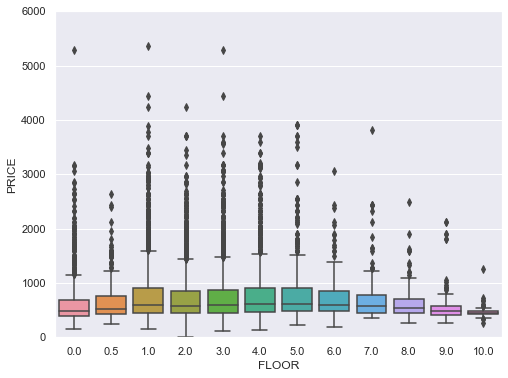

In [18]:
#box plot overallqual/saleprice
var = 'FLOOR'
data = pd.concat([df_o['PRICE'], df_o[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="PRICE", data=data)
fig.axis(ymin=0, ymax=6000);

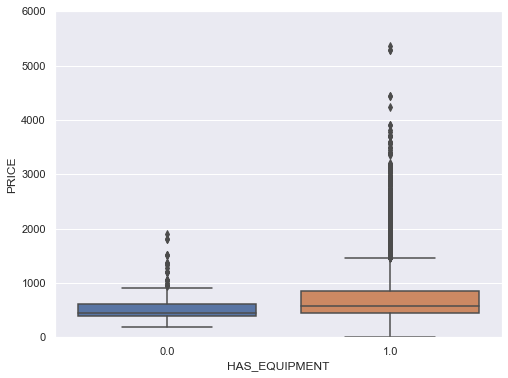

In [19]:
#box plot overallqual/saleprice
var = 'HAS_EQUIPMENT'
data = pd.concat([df_o['PRICE'], df_o[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="PRICE", data=data)
fig.axis(ymin=0, ymax=6000);

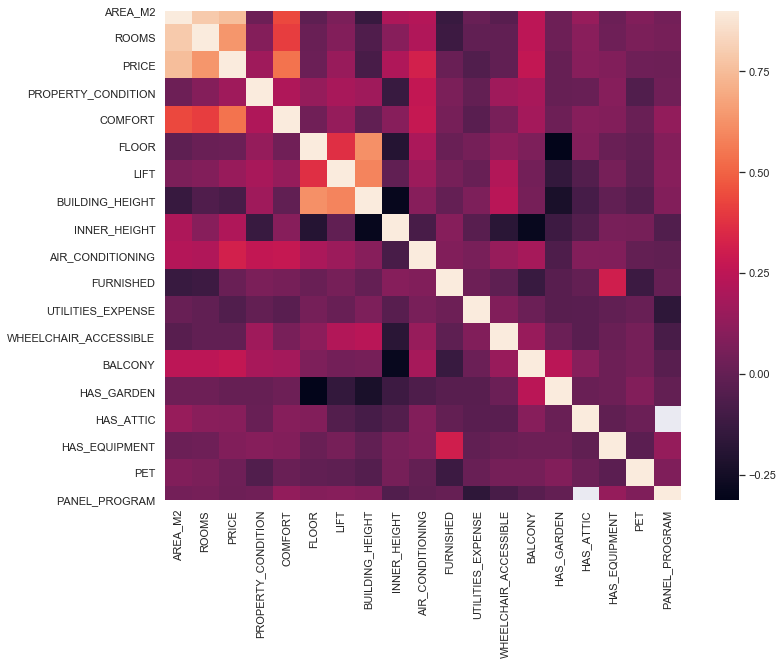

In [20]:
#correlation matrix
corrmat = df_o.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=0.9, square=True);

In [21]:
#missing data
total = df_o.isnull().sum().sort_values(ascending=False)
percent = (df_o.isnull().sum()/df_o.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)

,Total,Percent
PANEL_PROGRAM,12101,0.972202
ENERGY_USAGE,11294,0.907367
ORIENTATION,7634,0.613320
HAS_GARDEN,7232,0.581024
HAS_ATTIC,6027,0.484213
SMOKING,5837,0.468948
INNER_HEIGHT,5600,0.449908
PET,4990,0.400900
PARKING,4705,0.378003
BUILDING_HEIGHT,4167,0.334779


In [22]:
# dealing with missing data
# remove columns that have more than 25% missing data
# from the remainder, drop null values
df_o = df_o.drop((missing_data[missing_data['Percent'] > 0.25]).index,1)
df_o.dropna(inplace=True)

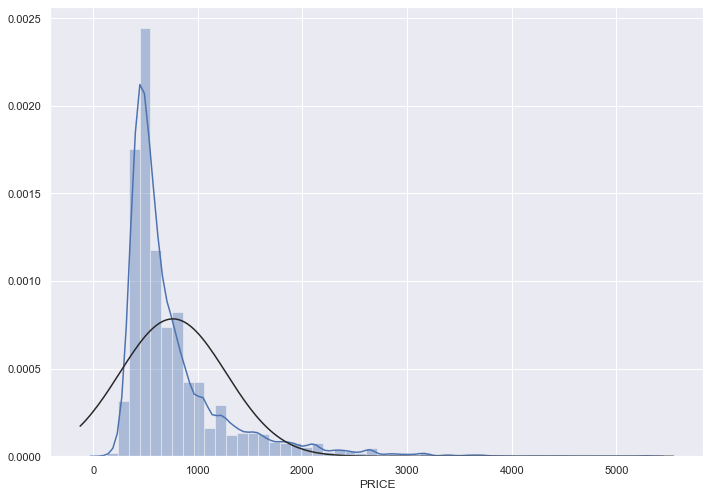

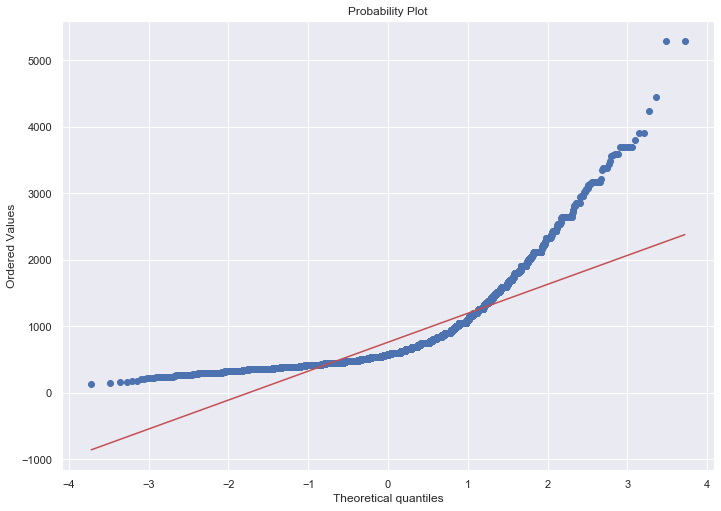

In [23]:
from scipy.stats import norm
# Check for normal distribution at PRICE
# histogram and normal probability plot
sns.distplot(df_o['PRICE'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_o['PRICE'], plot=plt)

In [24]:
# applying log transformation
df_o['PRICE'] = np.log1p(df_o['PRICE'])

Skewness: 0.926825
Kurtosis: 0.526544


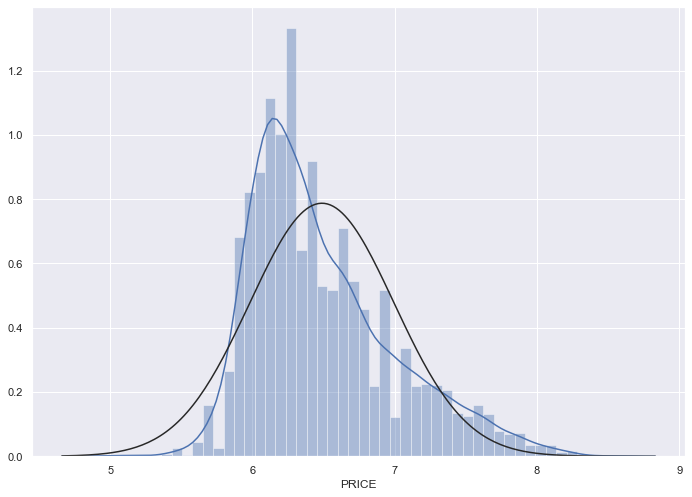

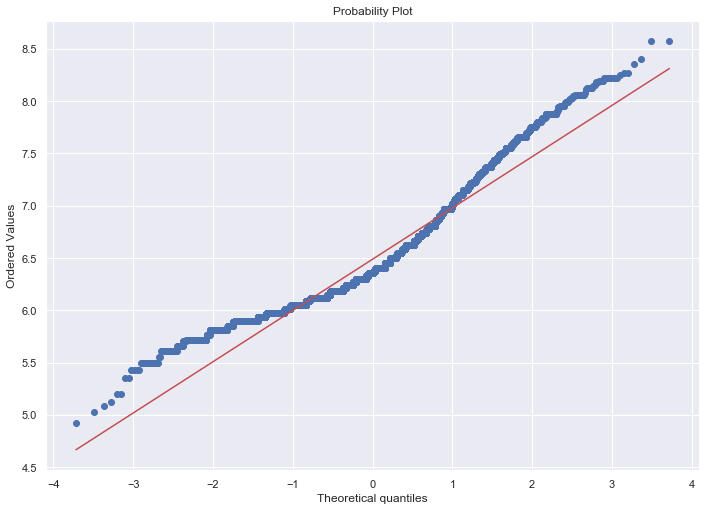

In [25]:
# Check for distribution after log transformation
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(df_o['PRICE'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_o['PRICE'], plot=plt)
# skewness and kurtosis
print("Skewness: %f" % df_o['PRICE'].skew())
print("Kurtosis: %f" % df_o['PRICE'].kurt())

In [26]:
#create column for new variable 
df_o['HAS_UTILITIES'] = pd.Series(len(df_o['UTILITIES_EXPENSE']), index=df_o.index)
df_o['HAS_UTILITIES'] = 0 
df_o.loc[df_o['UTILITIES_EXPENSE']>0,'HAS_UTILITIES'] = 1

In [27]:
# Separate categorical and numerical variables and
# one-hot encode categorical variables but exclude 'STREET' from the model
categorical = df_o.select_dtypes(include = ['object'])
categorical.drop(columns=['STREET'], inplace=True)
categorical = pd.get_dummies(categorical, prefix="", prefix_sep="")
numerical = df_o.select_dtypes(exclude = ['object'])
numerical.drop(columns=['PRICE'], inplace=True)


C:\Users\TamasMarton\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [28]:
# Store predictor variables
X = pd.concat([numerical, categorical], axis = 1)

# To use scikit-learn, change pandas dataframe to numpy array
X = X.values.astype('int')

In [29]:
# Store dependent variable
y = df_o['PRICE'].values.astype('float')
print('Dependent variable identified: Price in EUR')

Dependent variable identified: Price in EUR


In [30]:
# Standardize the data 
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
print('Data Standardized!')

Data Standardized!


In [31]:
# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)
print('Data split into training and testing set!')
print ('Train set size:', X_train.shape,  y_train.shape)
print ('Test set size:', X_test.shape,  y_test.shape)

Data split into training and testing set!
Train set size: (5531, 39) (5531,)
Test set size: (1383, 39) (1383,)


In [32]:
# Ridge regression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split

# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

RMSE on Training set : 0.2340206719933499
RMSE on Test set : 0.23398740035688523
Training R-squared: 0.7896181781662149
Test R-squared: 0.7938433090007997


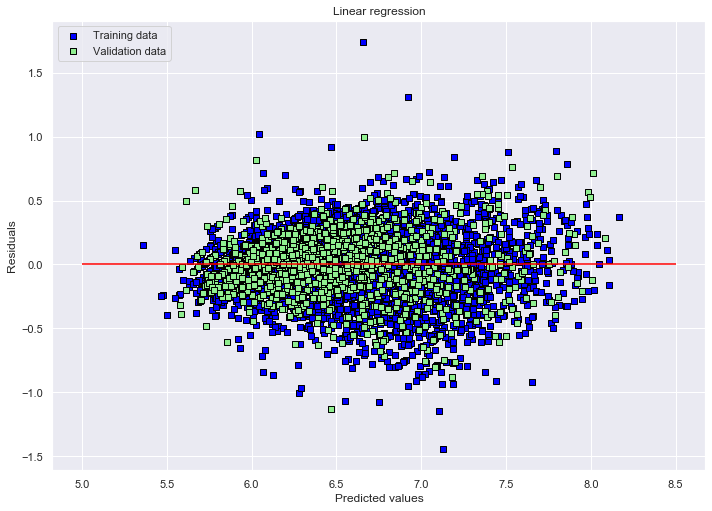

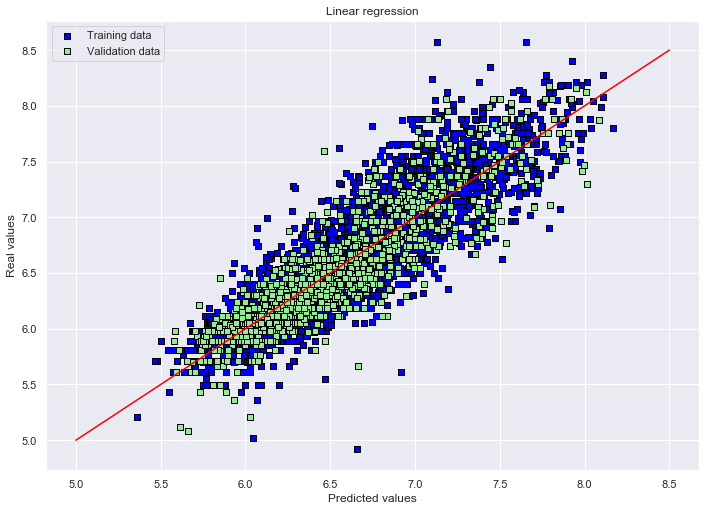

In [33]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Look at predictions on training and validation set
print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())
print('Training R-squared:', lr.score(X_train, y_train))
print('Test R-squared:', lr.score(X_test, y_test))
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", edgecolors = "black", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", edgecolors = "black", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 5.0, xmax = 8.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", edgecolors = "black", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", edgecolors = "black", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([5.0, 8.5], [5.0, 8.5], c = "red")
plt.show()

Best alpha : 20.0
Try again for more precision with alphas centered around 20.0
Best alpha : 28.0
Ridge RMSE on Training set : 0.23334824476055666
Ridge RMSE on Test set : 0.23394692529950184
Training R-squared: 0.7896055233237392
Test R-squared: 0.7937252595345254


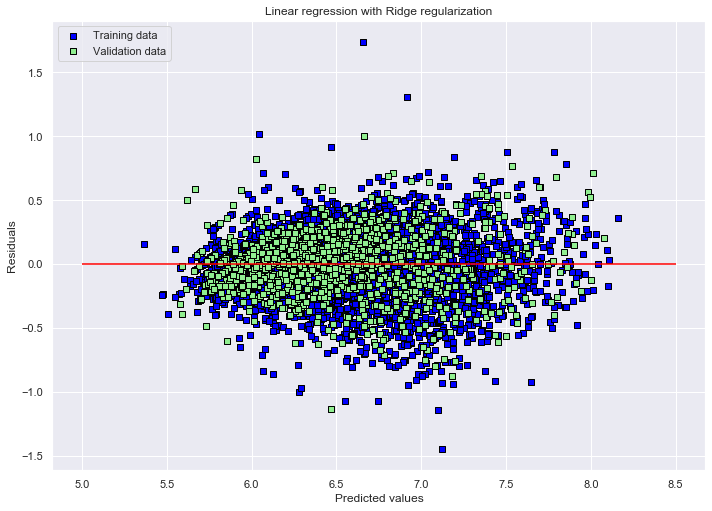

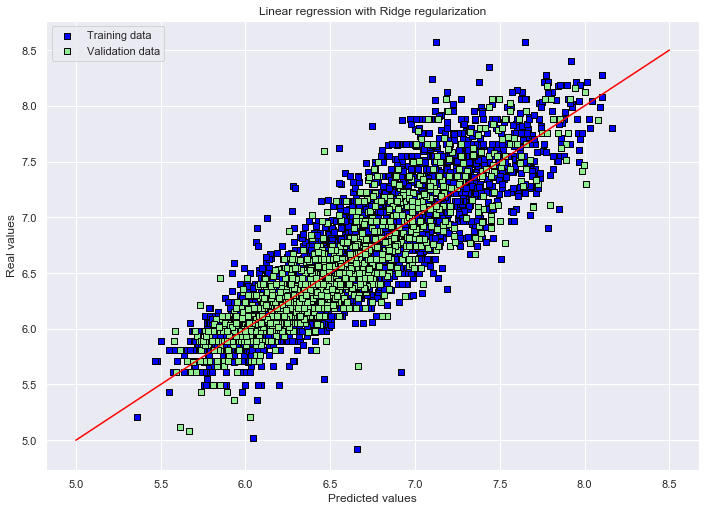

In [34]:
# 2* Ridge
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 15, 20, 25, 26, 27, 30, 35, 40, 45, 50, 60, 70])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .5, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Ridge RMSE on Training set :", rmse_cv_train(ridge).mean())
print("Ridge RMSE on Test set :", rmse_cv_test(ridge).mean())
print('Training R-squared:', ridge.score(X_train, y_train))
print('Test R-squared:', ridge.score(X_test, y_test))
y_train_rdg = ridge.predict(X_train)
y_test_rdg = ridge.predict(X_test)


# Plot residuals
plt.scatter(y_train_rdg, y_train_rdg - y_train, c = "blue", marker = "s",edgecolors = "black", label = "Training data")
plt.scatter(y_test_rdg, y_test_rdg - y_test, c = "lightgreen", marker = "s",edgecolors = "black", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 5.0, xmax = 8.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_rdg, y_train, c = "blue", marker = "s",edgecolors = "black", label = "Training data")
plt.scatter(y_test_rdg, y_test, c = "lightgreen", marker = "s",edgecolors = "black", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([5.0, 8.5], [5., 8.5], c = "red")
plt.show()

Best alpha : 0.0006
Try again for more precision with alphas centered around 0.0006
Best alpha : 0.0006899999999999999
Lasso RMSE on Training set : 0.23329086040992725
Lasso RMSE on Test set : 0.2338900501204857
Training R-squared: 0.7895588644664127
Test R-squared: 0.7937351843983895


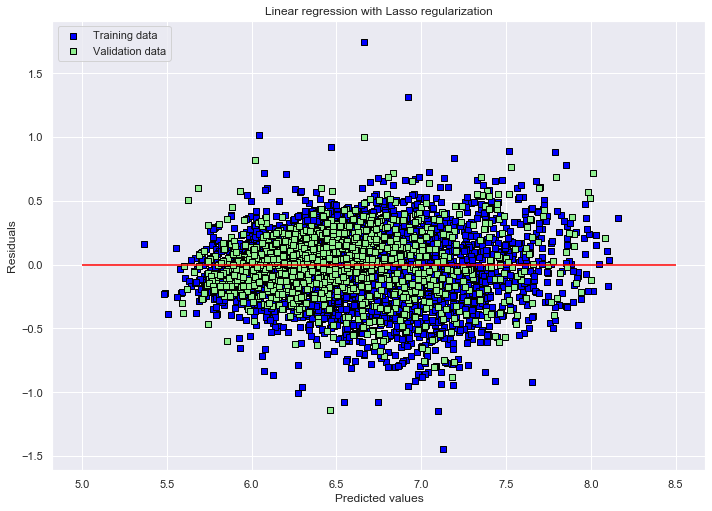

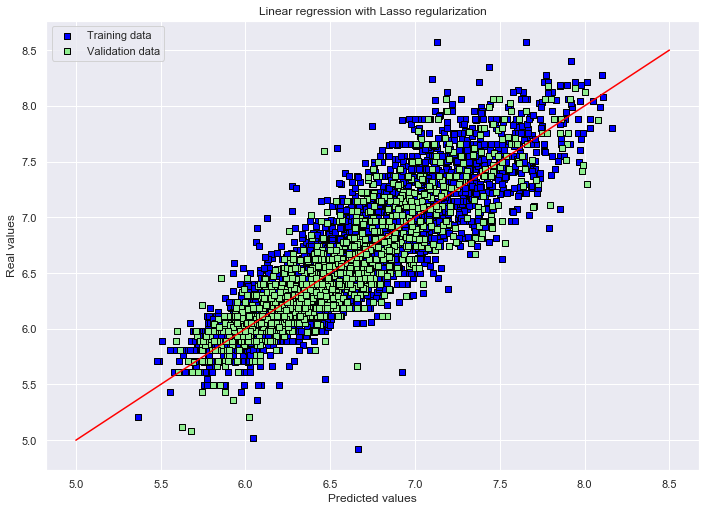

In [35]:
# Lasso regression
from sklearn.linear_model import Lasso, LassoCV

# 3* Lasso
lasso = LassoCV(alphas = [0.00005,0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
print("Lasso RMSE on Test set :", rmse_cv_test(lasso).mean())
print('Training R-squared:', lasso.score(X_train, y_train))
print('Test R-squared:', lasso.score(X_test, y_test))
y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)

# Plot residuals
plt.scatter(y_train_las, y_train_las - y_train, c = "blue", marker = "s", edgecolors = "black", label = "Training data")
plt.scatter(y_test_las, y_test_las - y_test, c = "lightgreen", marker = "s", edgecolors = "black", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 5.0, xmax = 8.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_las, y_train, c = "blue", marker = "s", edgecolors = "black", label = "Training data")
plt.scatter(y_test_las, y_test, c = "lightgreen", marker = "s", edgecolors = "black", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([5, 8.5], [5, 8.5], c = "red")
plt.show()

Best l1_ratio : 0.1
Best alpha : 0.006
Try again for more precision with l1_ratio centered around 0.1
Best l1_ratio : 0.11000000000000001
Best alpha : 0.006
Now try again for more precision on alpha, with l1_ratio fixed at 0.11000000000000001 and alpha centered around 0.006
Best l1_ratio : 0.11000000000000001
Best alpha : 0.006
ElasticNet RMSE on Training set : 0.23327714915768719
ElasticNet RMSE on Test set : 0.23384854050281428
Training R-squared: 0.7895420045224061
Test R-squared: 0.7935834111063222


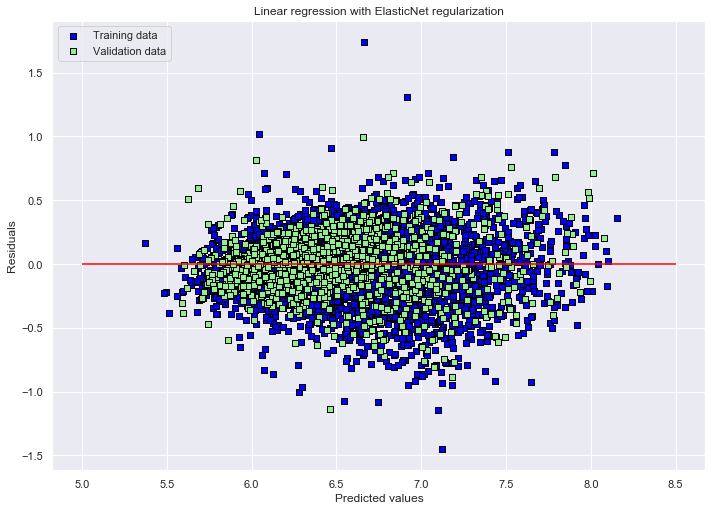

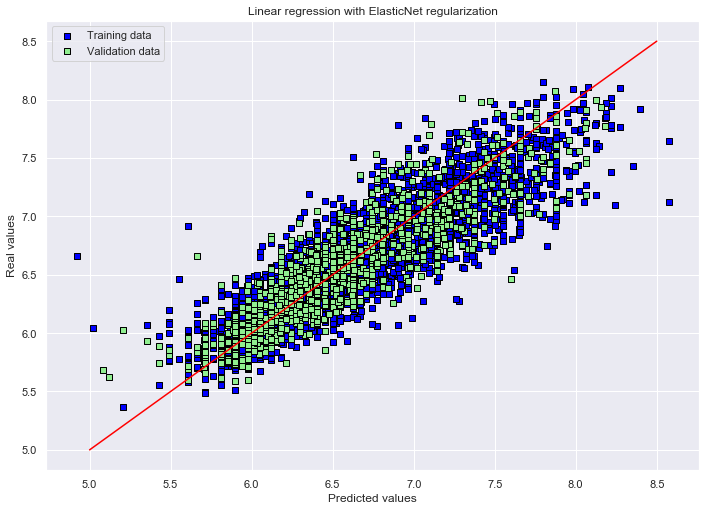

In [36]:
# ElasticNet regression
from sklearn.linear_model import ElasticNet, ElasticNetCV

# 4* ElasticNet
elasticNet = ElasticNetCV(l1_ratio = [0.05, 0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Try again for more precision with l1_ratio centered around " + str(ratio))
elasticNet = ElasticNetCV(l1_ratio = [ratio * .85, ratio * .9, ratio * .95, ratio, ratio * 1.05, ratio * 1.1, ratio * 1.15],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Now try again for more precision on alpha, with l1_ratio fixed at " + str(ratio) + 
      " and alpha centered around " + str(alpha))
elasticNet = ElasticNetCV(l1_ratio = ratio,
                          alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, 
                                    alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, 
                                    alpha * 1.35, alpha * 1.4], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("ElasticNet RMSE on Training set :", rmse_cv_train(elasticNet).mean())
print("ElasticNet RMSE on Test set :", rmse_cv_test(elasticNet).mean())
print('Training R-squared:', elasticNet.score(X_train, y_train))
print('Test R-squared:', elasticNet.score(X_test, y_test))
y_train_ela = elasticNet.predict(X_train)
y_test_ela = elasticNet.predict(X_test)

# Plot residuals
plt.scatter(y_train_ela, y_train_ela - y_train, c = "blue", marker = "s", edgecolors = "black", label = "Training data")
plt.scatter(y_test_ela, y_test_ela - y_test, c = "lightgreen", marker = "s", edgecolors = "black", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 5.0, xmax = 8.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train, y_train_ela, c = "blue", marker = "s", edgecolors = "black", label = "Training data")
plt.scatter(y_test, y_test_ela, c = "lightgreen", marker = "s", edgecolors = "black", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([5.0, 8.5], [5.0, 8.5], c = "red")
plt.show()

In [37]:
# Create dataframe that contains the name of the predictor and the associated coefficient
coefs = pd.DataFrame(elasticNet.coef_, columns=['Coefficients'])
cols = pd.DataFrame(list(numerical.columns) + list(categorical.columns), columns = ['Predictor variables'])
results = cols.join(coefs, sort=False)
results['Coefficients'] = (np.exp(results['Coefficients'])-1) * 100

In [38]:
print(results)

      Predictor variables  Coefficients
0                 AREA_M2     31.415844
1                   ROOMS      9.282931
2      PROPERTY_CONDITION      6.805439
3                   FLOOR     -0.952918
4                    LIFT      2.148614
5        AIR_CONDITIONING      5.995776
6               FURNISHED      3.165498
7       UTILITIES_EXPENSE      0.000000
8   WHEELCHAIR_ACCESSIBLE     -0.293777
9                 BALCONY      3.398109
10          HAS_EQUIPMENT      0.901385
11          HAS_UTILITIES     -3.400471
12                      I      3.494835
13                     II      2.394922
14                    III     -0.742370
15                     IV     -1.337018
16                     IX     -0.205068
17                      V      8.687556
18                     VI      5.038028
19                    VII      1.078808
20                   VIII     -0.695274
21                      X     -1.613341
22                     XI     -0.457917
23                    XII      1.159744


In [39]:
# Send data to csv
df_o.to_csv('reg_data.csv',index=False, encoding='utf-8')